In [ ]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras

In [ ]:
dir_seg = '/content/drive/MyDrive/All-datasets/dataset1/annotations_prepped_train/'
dir_img = '/content/drive/MyDrive/All-datasets/dataset1/images_prepped_train/'

In [ ]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
ldseg = np.array(os.listdir(dir_seg))
fnm = ldseg[0]
print(fnm)

0016E5_05760.png


In [ ]:
seg = cv2.imread(dir_seg + fnm)
ldseg = np.array(os.listdir(dir_img))
fnm = ldseg[0]
img_is = cv2.imread(dir_img + fnm)
print(dir_img+fnm)
print(dir_seg+fnm)

/content/drive/MyDrive/All-datasets/dataset1/images_prepped_train/0016E5_07320.png
/content/drive/MyDrive/All-datasets/dataset1/annotations_prepped_train/0016E5_07320.png


seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]

 [[3 3 3]
  [3 3 3]
  [3 3 3]
  ...
  [3 3 3]
  [3 3 3]
  [3 3 3]]]
minimum seg = 1, maximum seg = 11, Total number of segmentation classes = 6


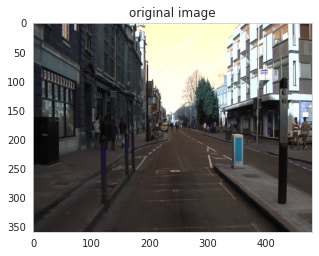

In [ ]:
print("seg.shape={}, img_is.shape={}".format(seg.shape, img_is.shape))
print(seg)
mi, ma = np.min(seg), np.max(seg)
n_classes = 6
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi, ma, n_classes))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

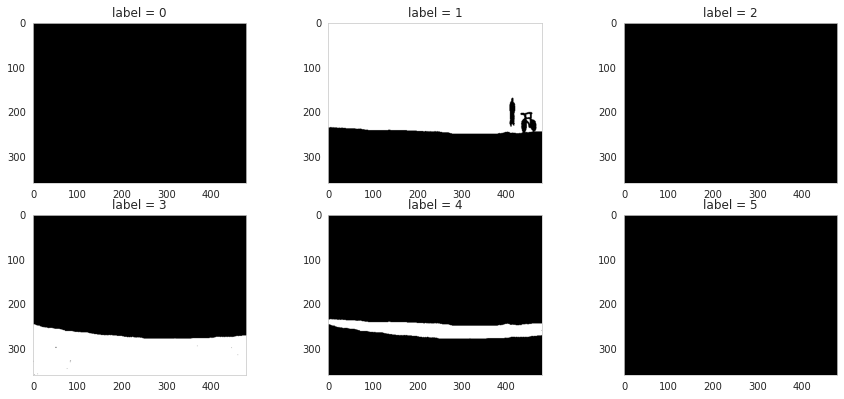

In [ ]:
fig = plt.figure(figsize=(15,10))
for k in range(6):
  ax = fig.add_subplot(3,n_classes/2,k+1)
  ax.imshow((seg == k)*1.0)
  ax.set_title("label = {}".format(k))
plt.show()

(360, 480, 3)
(360, 480, 3)


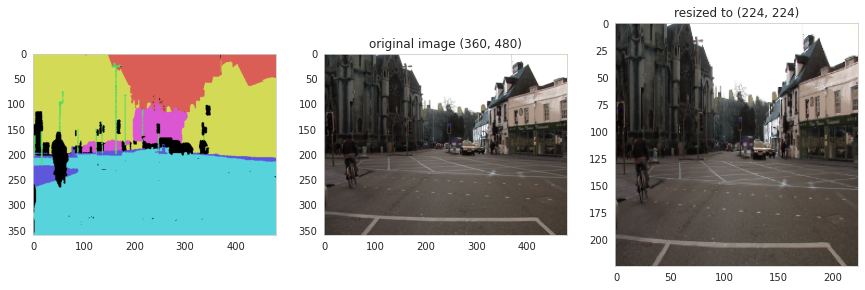

(360, 480, 3)
(360, 480, 3)


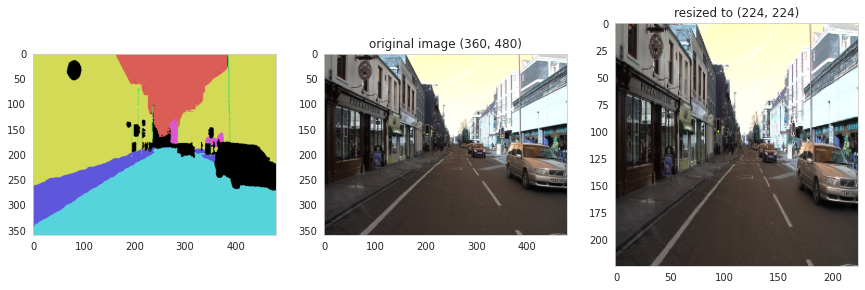

(360, 480, 3)
(360, 480, 3)


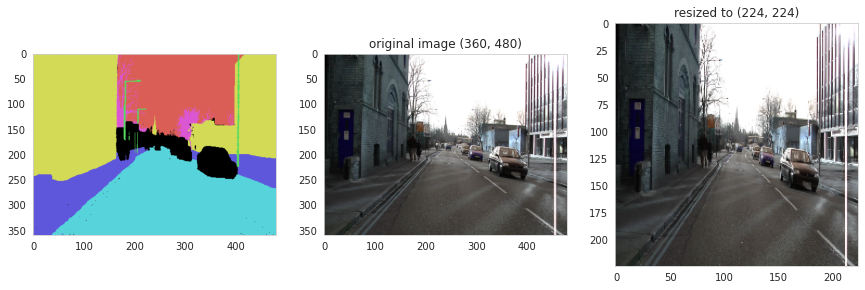

In [ ]:
import random
def give_color_to_seg_img(seg, n_classes):
  seg : (input_width, input_height, 3)
  if len(seg.shape)==3:
    seg=seg[:,:,0]
    seg_img = np.zeros((seg.shape[0], seg.shape[1],3)).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
      segc = (seg == c)
      seg_img[:,:,0] += (segc*(colors[c][0]))
      seg_img[:,:,1] += (segc*(colors[c][1]))
      seg_img[:,:,2] += (segc*(colors[c][2]))
    return (seg_img)

input_height, input_width = 224, 224
output_height, output_width = 224, 224

ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
  fnm = fnm.split(".")[0]
  seg = cv2.imread(dir_seg + fnm + ".png")
  img_is = cv2.imread(dir_img + fnm + ".png")
  seg_img = give_color_to_seg_img(seg, n_classes)

  fig = plt.figure(figsize=(20,40))
  ax = fig.add_subplot(1,4,1)
  ax.imshow(seg_img)

  ax = fig.add_subplot(1,4,2)
  ax.imshow(img_is/255)
  ax.set_title("original image {}".format(img_is.shape[:2]))

  ax = fig.add_subplot(1,4,3)
  ax.imshow(cv2.resize(seg_img, (input_height, input_width)))

  print(seg_img.shape)

  ax.imshow(cv2.resize(img_is,(output_height, output_width))/255.0)
  print(img_is.shape)
  ax.set_title("resized to {}".format((output_height, output_width)))
  plt.show()

In [ ]:
def getImageArr(path, width, height):
  img = cv2.imread(path, 1)
  img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
  return img

def getSegmentationArr(path, nClasses, width, height):
  seg_labels = np.zeros((height, width, nClasses))
  img = cv2.imread(path, 1)
  img = cv2.resize(img, (width, height))
  img = img[:, :, 0]

  for c in range(nClasses):
    seg_labels[:, :, c] = (img == c).astype(int)
  return seg_labels

images = os.listdir(dir_img)
images.sort()
segmentations = os.listdir(dir_seg)
segmentations.sort()

X = []
Y = []
for im, seg in zip(images, segmentations):
  X.append(getImageArr(dir_img + im, input_width, input_height))
  Y.append(getSegmentationArr(dir_seg + seg, n_classes, output_width, output_height))

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

(367, 224, 224, 3) (367, 224, 224, 6)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.compat.v1.keras.backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd

VGG_Weights_path = '/content/drive/MyDrive/All-datasets/dataset1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def FCN8(nClasses, input_height=224, input_width=224):
  assert input_height%32 == 0
  assert input_width%32 == 0
  IMAGE_ORDERING = "channels_last"
  img_input = Input(shape=(input_height, input_width,3))

  x = Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1", data_format=IMAGE_ORDERING)(img_input)
  x = Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv2", data_format=IMAGE_ORDERING)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool", data_format=IMAGE_ORDERING)(x)
  f1 = x

  x = Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv1", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv2", data_format=IMAGE_ORDERING)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool", data_format=IMAGE_ORDERING)(x)
  f2 = x

  x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv1", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv2", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv3", data_format=IMAGE_ORDERING)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool", data_format=IMAGE_ORDERING)(x)
  pool3 = x

  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv1", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv2", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv3", data_format=IMAGE_ORDERING)(x)
  pool4 = MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool", data_format=IMAGE_ORDERING)(x)

  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv1", data_format=IMAGE_ORDERING)(pool4)
  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv2", data_format=IMAGE_ORDERING)(x)
  x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv3", data_format=IMAGE_ORDERING)(x)
  pool5 = MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool", data_format=IMAGE_ORDERING)(x)


  vgg = Model(img_input, pool5)
  vgg.load_weights(VGG_Weights_path)
  n = 4096
  o = (Conv2D(n, (7, 7), activation="relu", padding="same", name="conv6", data_format=IMAGE_ORDERING))(pool5)
  conv7 = (Conv2D(n, (1, 1), activation="relu", padding="same", name="conv7", data_format=IMAGE_ORDERING))(o)

  conv7_4 = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(4,4), use_bias=False, data_format=IMAGE_ORDERING)(conv7)
  pool411 = (Conv2D(nClasses, (1, 1), activation="relu", padding="same", name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
  pool411_2 = (Conv2DTranspose(nClasses, kernel_size=(2,2), strides=(2,2), use_bias=False, data_format=IMAGE_ORDERING))(pool411)
  pool311 = (Conv2D(nClasses, (1, 1), activation="relu", padding="same", name="pool3_11", data_format=IMAGE_ORDERING))(pool3)


  o = Add(name="add")([pool411_2, pool311, conv7_4])
  o = Conv2DTranspose(nClasses, kernel_size=(8,8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
  o = (Activation('softmax'))(o)

  model = Model(img_input, o)

  return model

model = FCN8(nClasses = n_classes,
             input_height=224,
             input_width=224)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.70
index_train = np.random.choice(X.shape[0], int(X.shape[0]*train_rate), replace=False)
index_test = list(set(range(X.shape[0])) - set(index_train))
X, Y = shuffle(X, Y)
X_train, y_train = X[index_train], Y[index_train]
X_test, y_test = X[index_test], Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(256, 224, 224, 3) (256, 224, 224, 6)
(111, 224, 224, 3) (111, 224, 224, 6)


In [ ]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(learning_rate=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])

In [ ]:
hist1 = model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=50,epochs=5,verbose=1)

Epoch 1/5
6/6 [==============================] - 730s 119s/step - loss: 1.6698 - accuracy: 0.1637 - val_loss: 1.5752 - val_accuracy: 0.1640
Epoch 2/5
6/6 [==============================] - 741s 122s/step - loss: 1.5513 - accuracy: 0.1645 - val_loss: 1.5744 - val_accuracy: 0.1664
Epoch 3/5
6/6 [==============================] - 747s 123s/step - loss: 1.5508 - accuracy: 0.1677 - val_loss: 1.5741 - val_accuracy: 0.1695
Epoch 4/5
6/6 [==============================] - 744s 123s/step - loss: 1.5505 - accuracy: 0.1702 - val_loss: 1.5736 - val_accuracy: 0.1712
Epoch 5/5
6/6 [==============================] - 747s 123s/step - loss: 1.5499 - accuracy: 0.1729 - val_loss: 1.5729 - val_accuracy: 0.1747


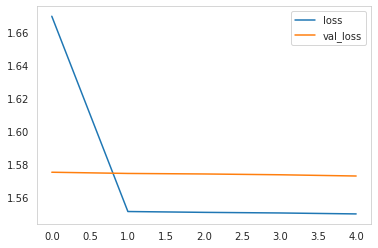

In [ ]:
for key in ['loss', 'val_loss']:
  plt.plot(hist1.history[key], label=key)

plt.legend()
plt.show()

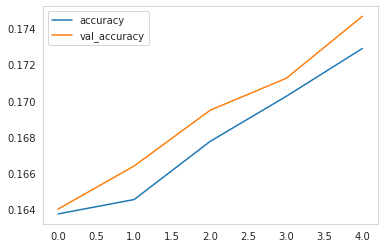

In [ ]:
for key in ['accuracy', 'val_accuracy']:
  plt.plot(hist1.history[key], label=key)

plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape, y_predi.shape)

def IoU(Yi, y_predi):
  IoUs = []
  Nclass = 6
  for c in range(Nclass):
    TP = np.sum((Yi == c)&(y_predi == c))
    FP = np.sum((Yi != c)&(y_predi == c))
    FN = np.sum((Yi == c)&(y_predi != c))
    IoU = TP/float(TP + FP + FN)
    print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
    IoUs.append(IoU)
  mIoU = np.mean(IoUs)
  print("____________________")
  print("Mean IoU: {:4.3f}".format(mIoU))

IoU(y_testi, y_predi)

(111, 224, 224) (111, 224, 224)
class 00: #TP=263831, #FP=688896, #FN=1278036, IoU=0.118
class 01: #TP=195569, #FP=533480, #FN=1152648, IoU=0.104
class 02: #TP= 11342, #FP=918080, #FN=57109, IoU=0.011
class 03: #TP=370294, #FP=737376, #FN=1412105, IoU=0.147
class 04: #TP= 53539, #FP=941736, #FN=243441, IoU=0.043
class 05: #TP= 78328, #FP=777065, #FN=453294, IoU=0.060
____________________
Mean IoU: 0.081


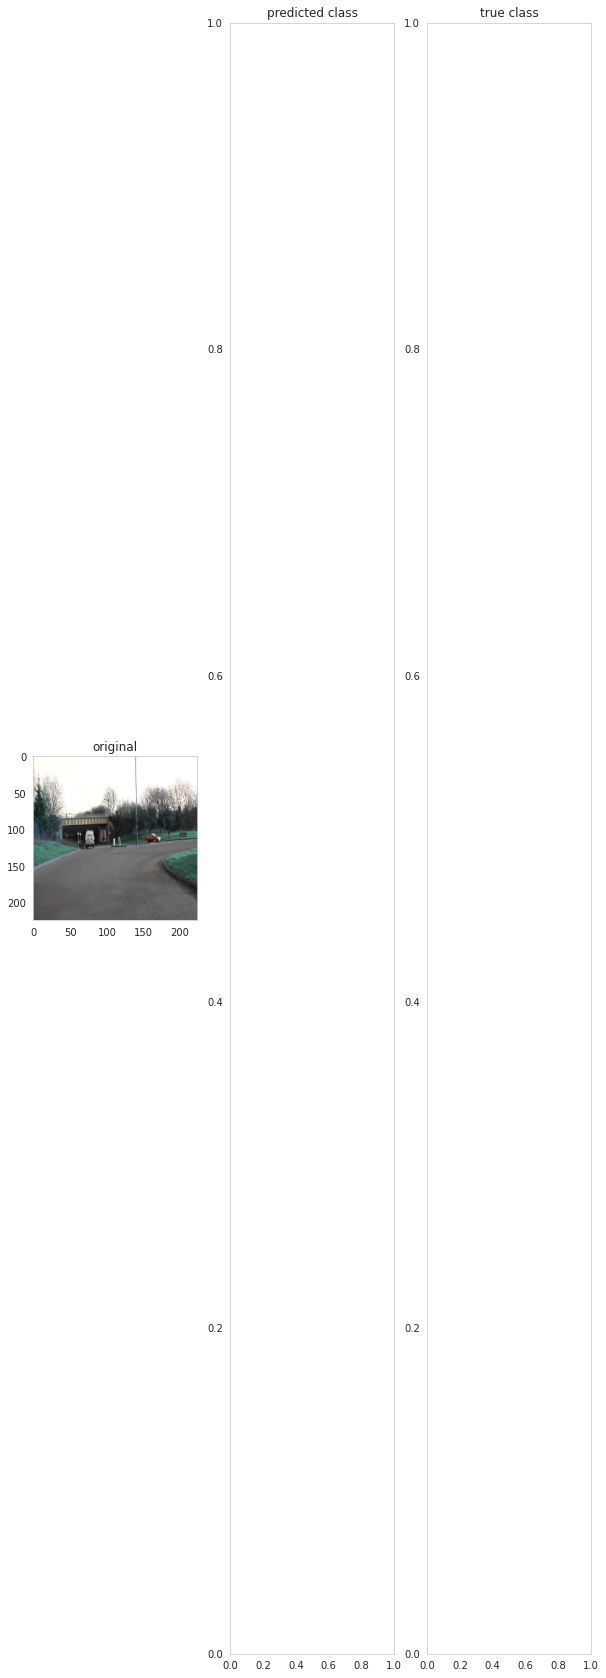

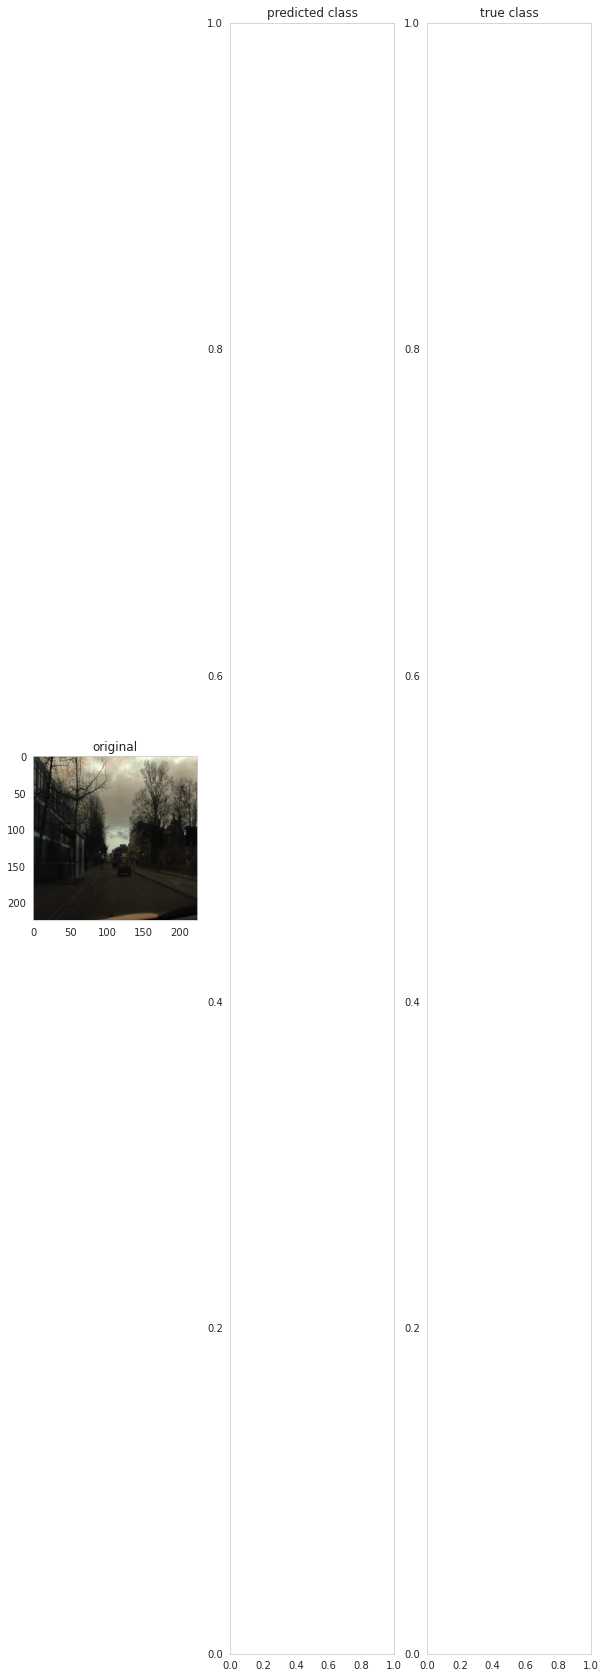

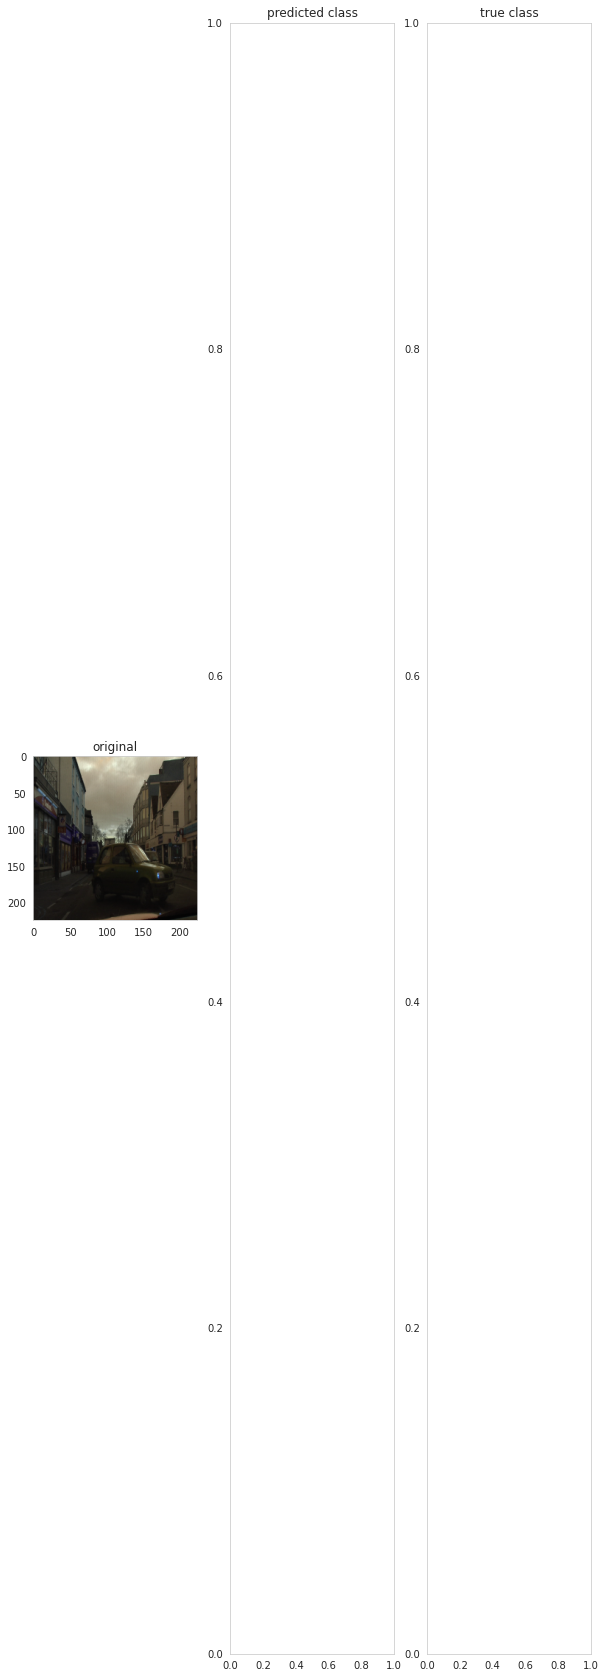

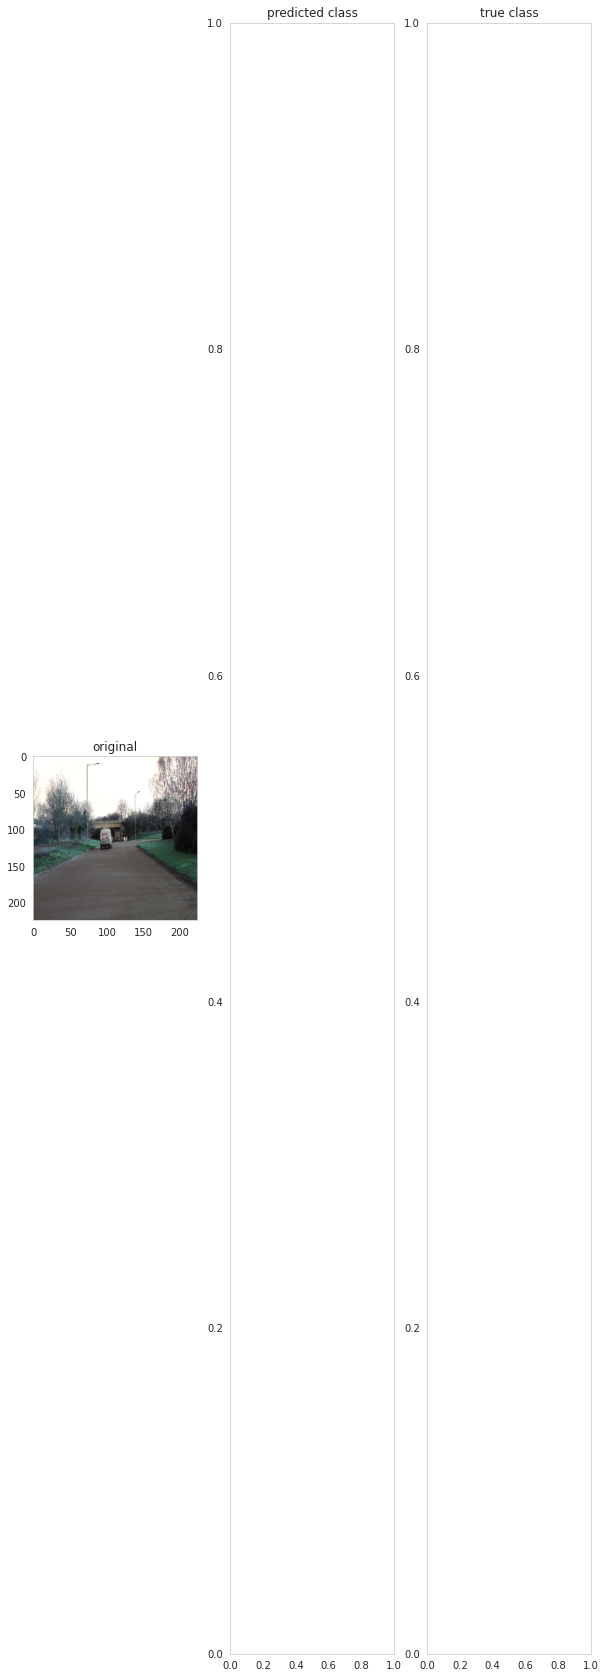

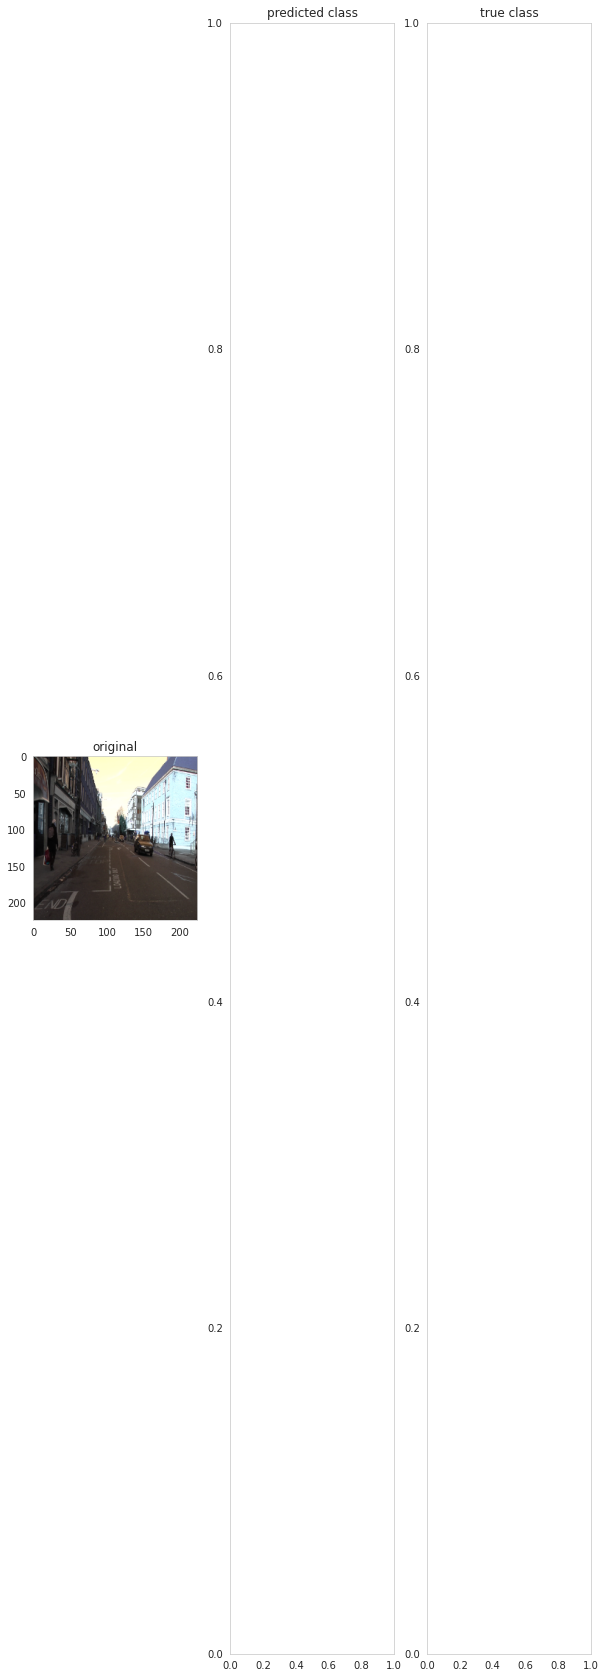

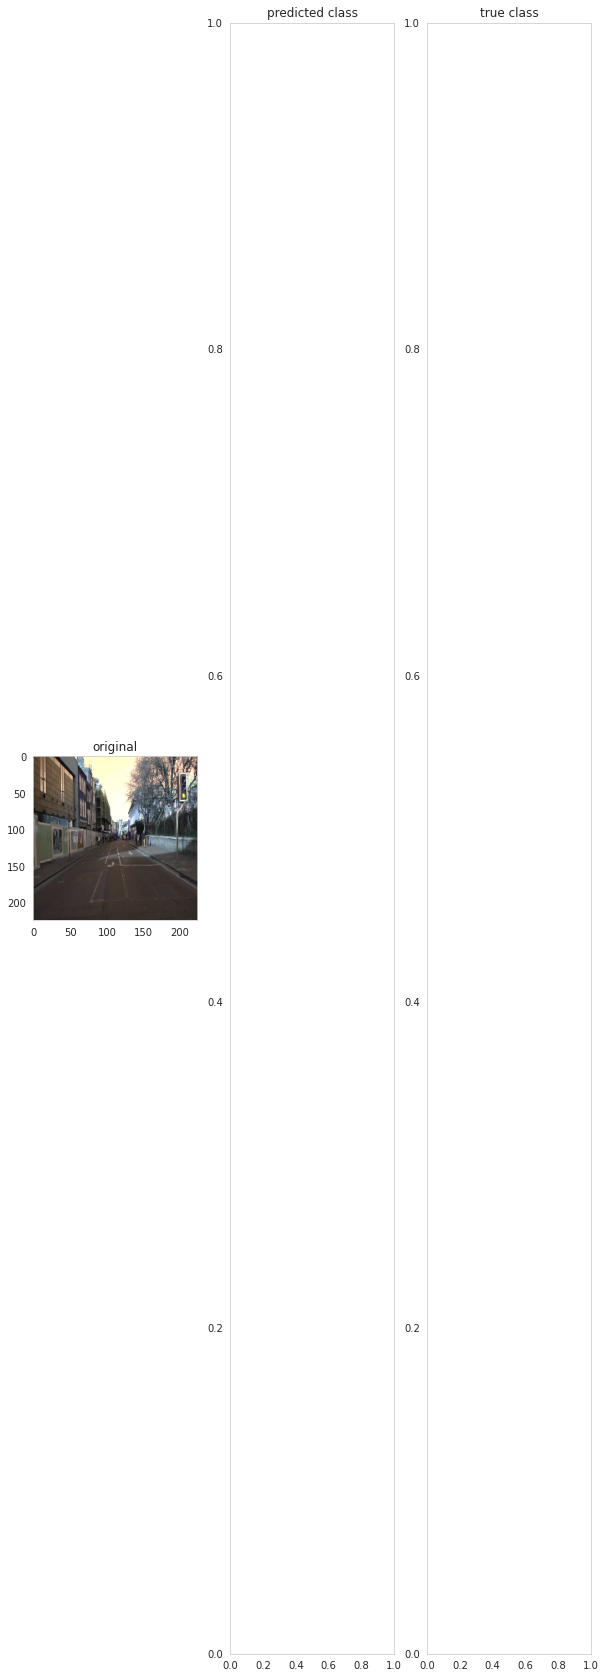

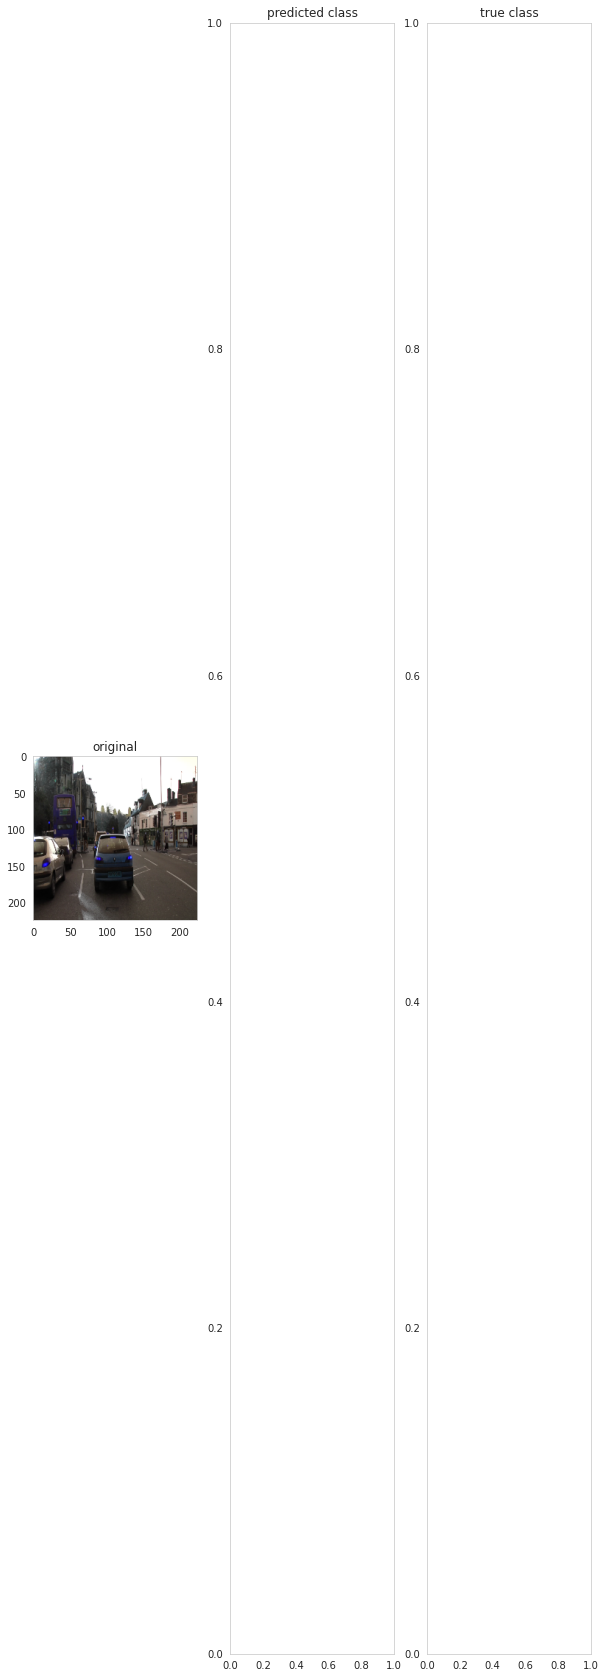

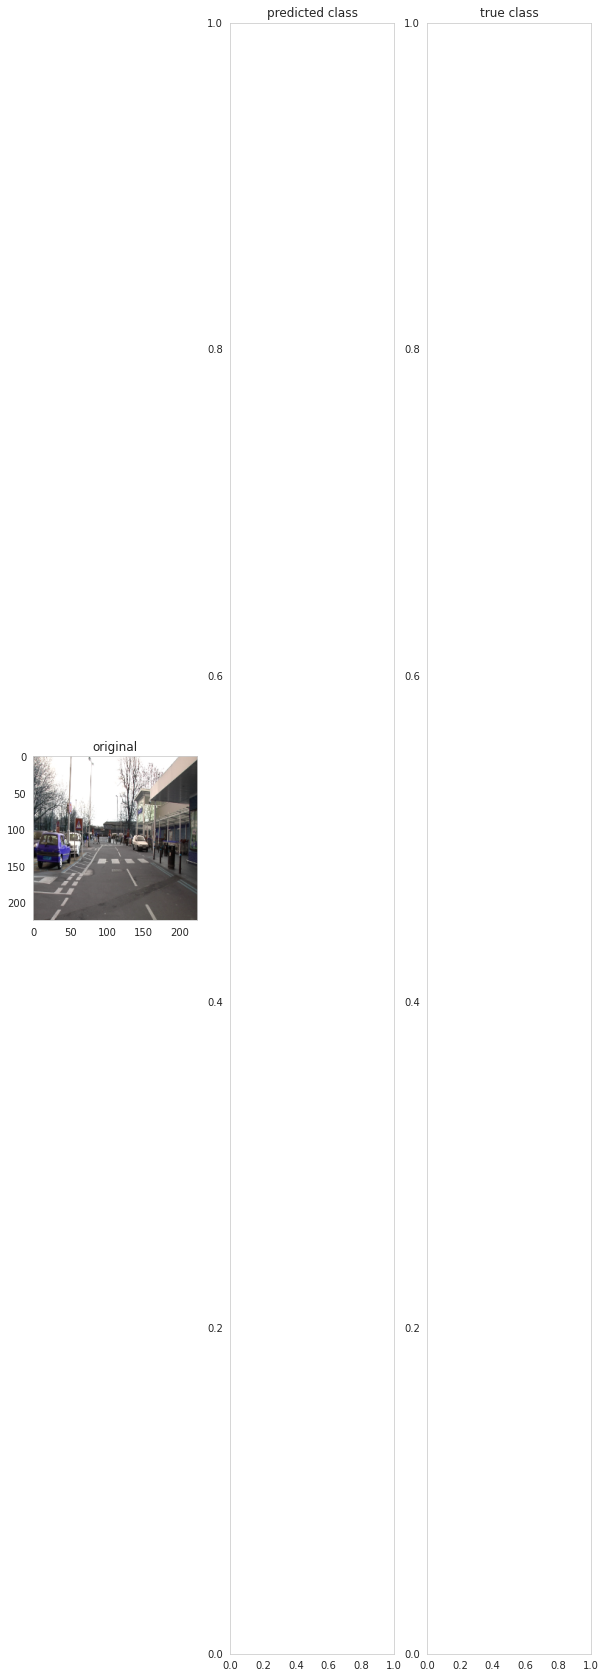

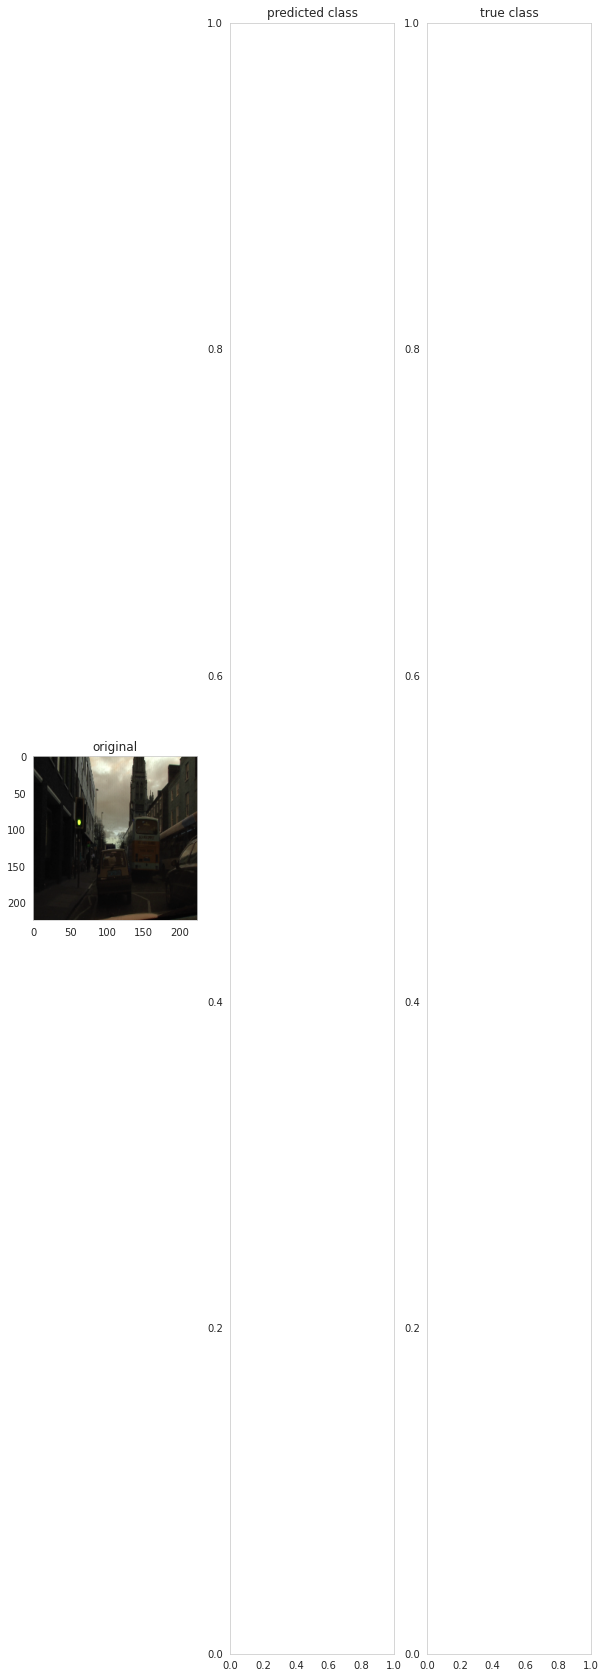

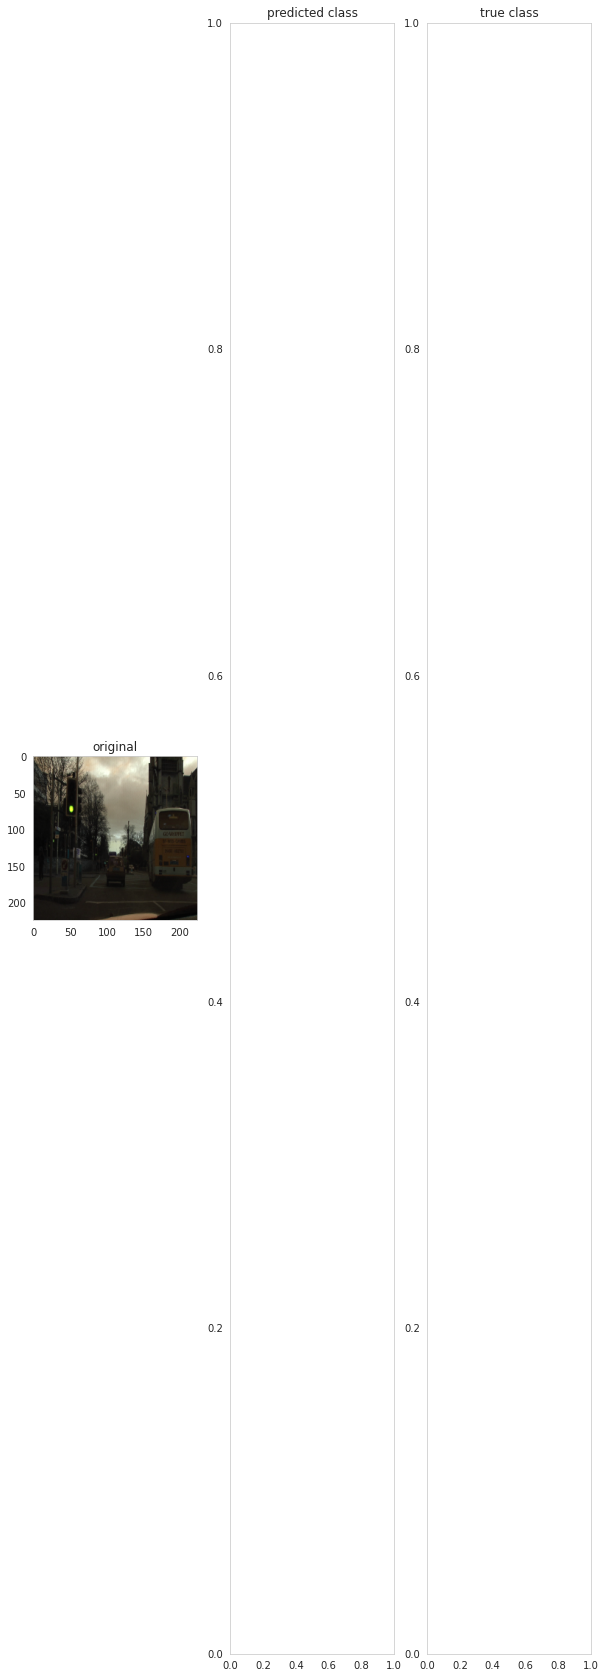

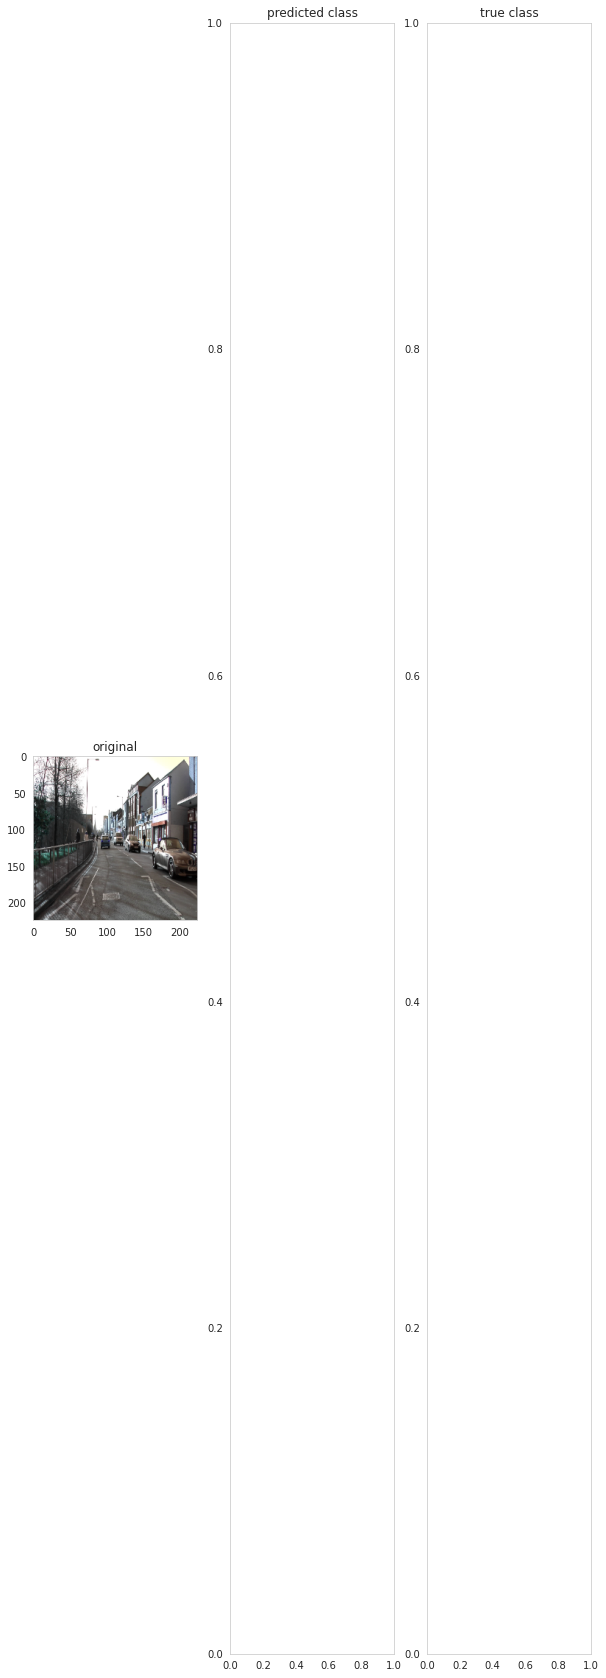

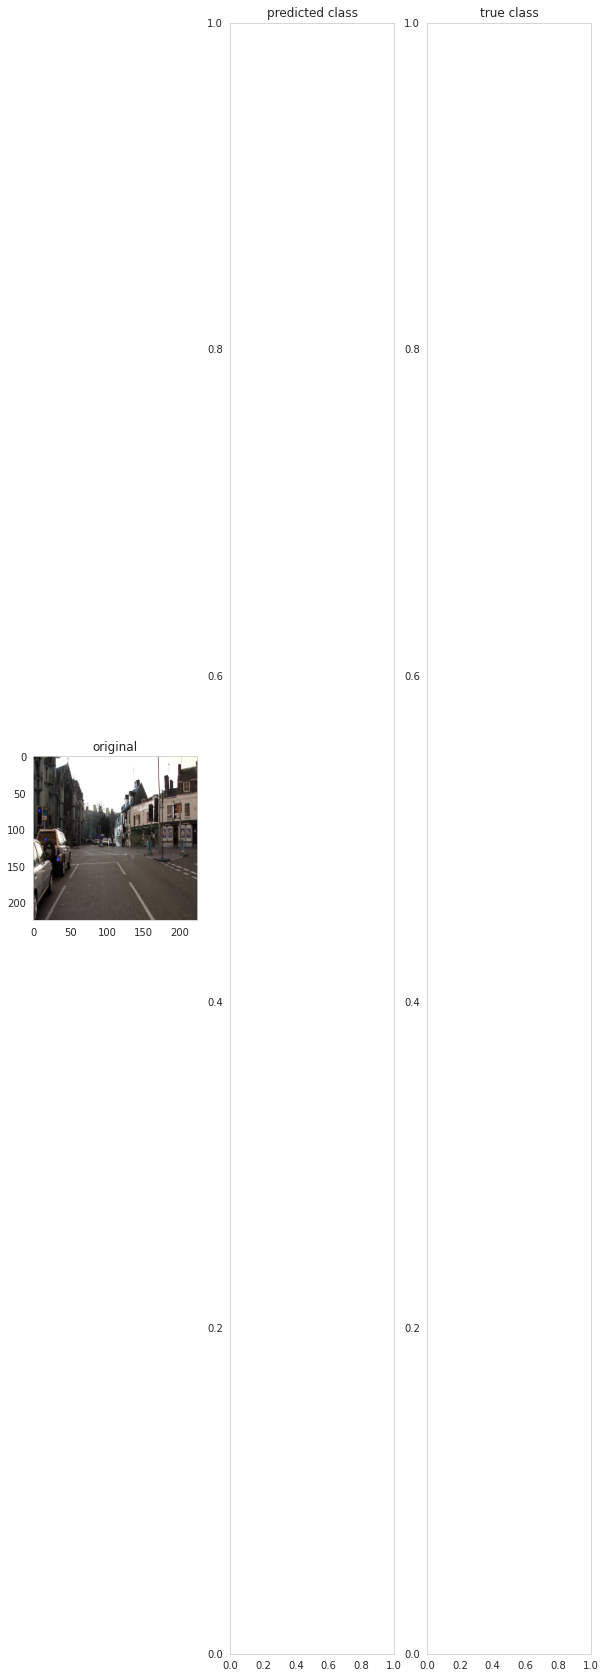

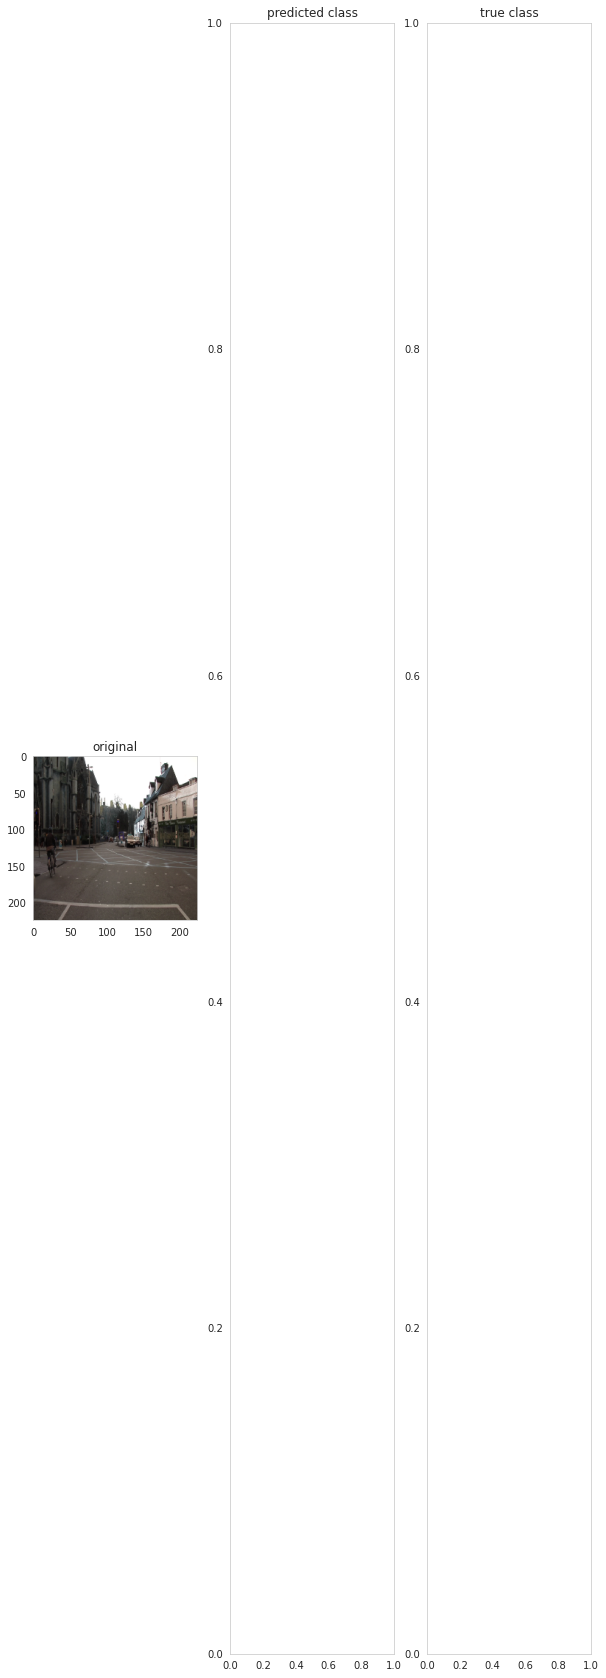

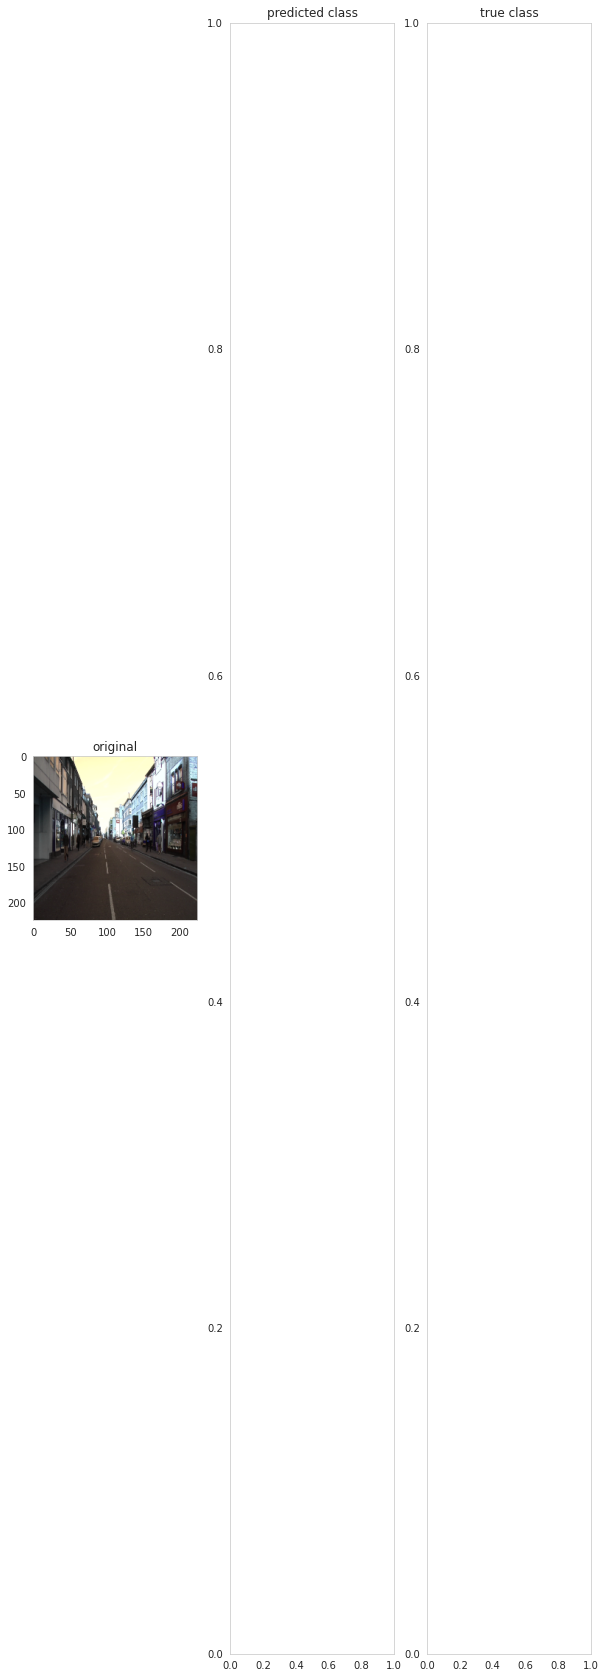

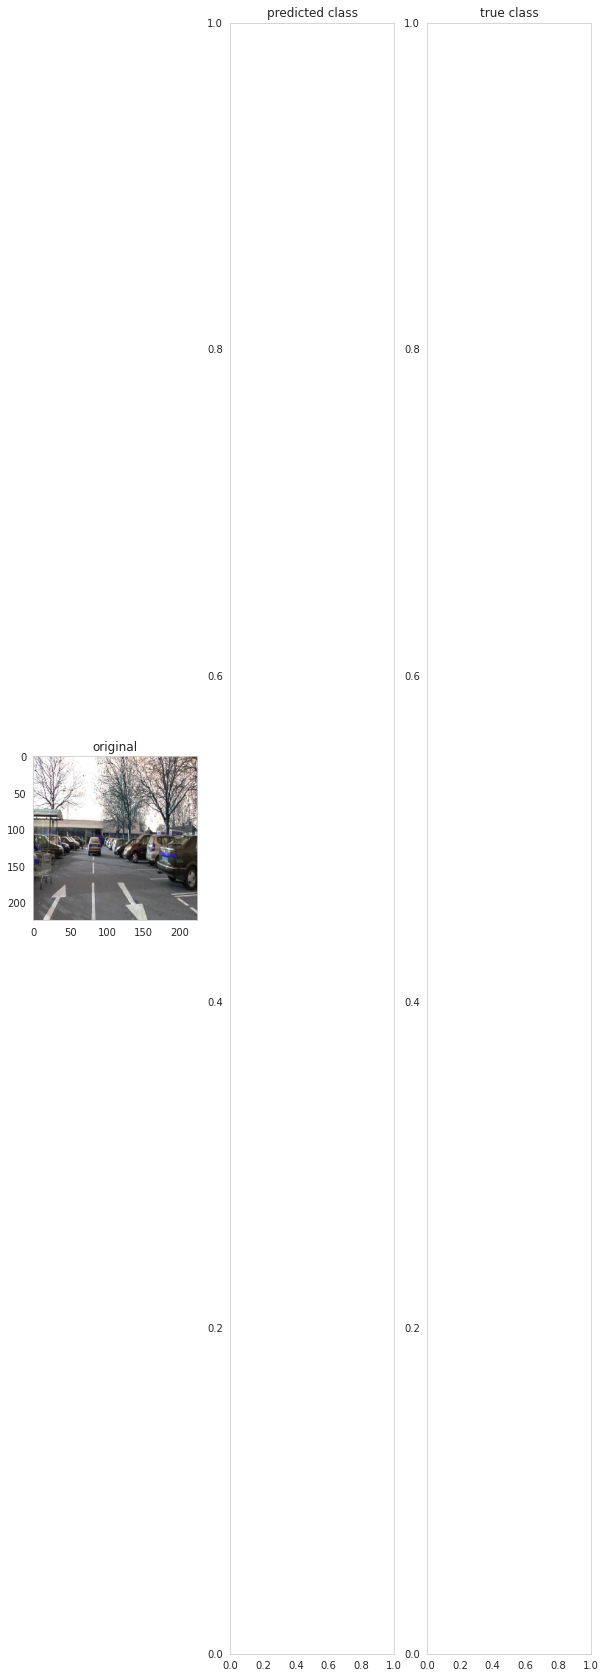

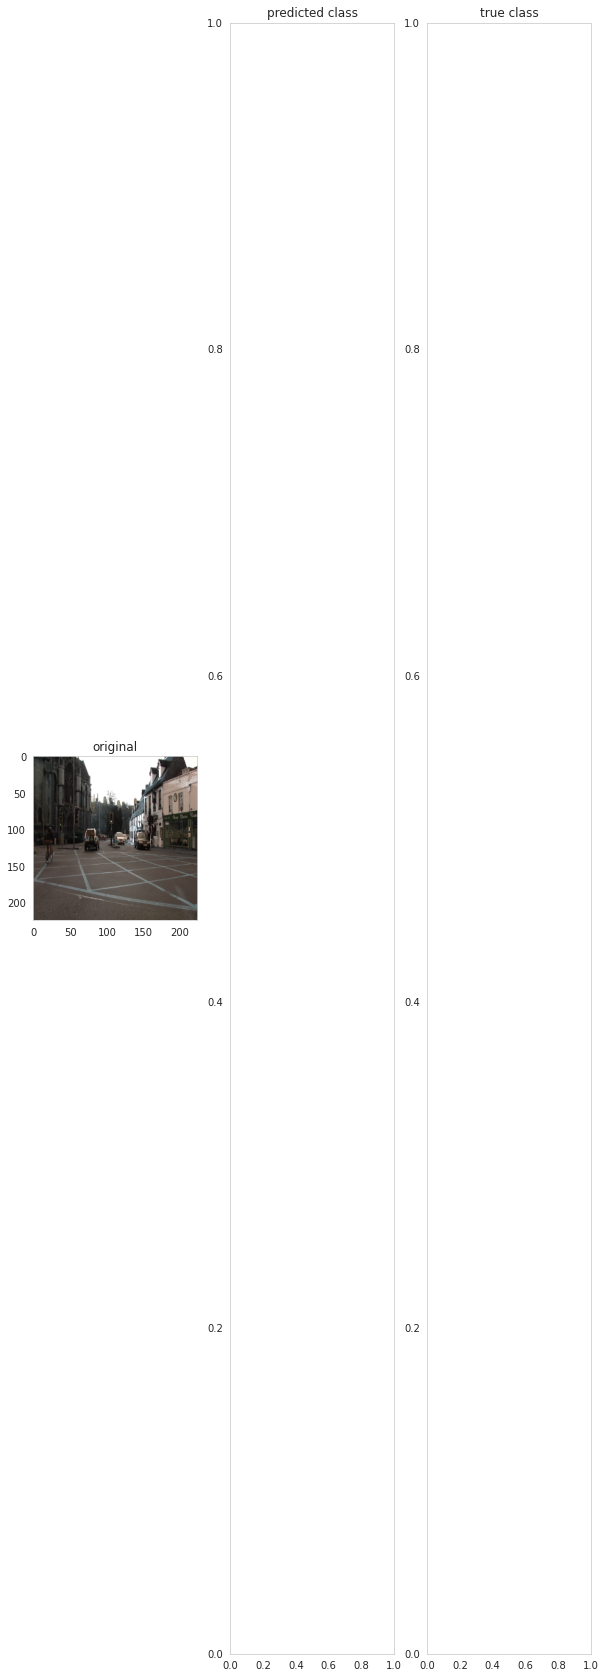

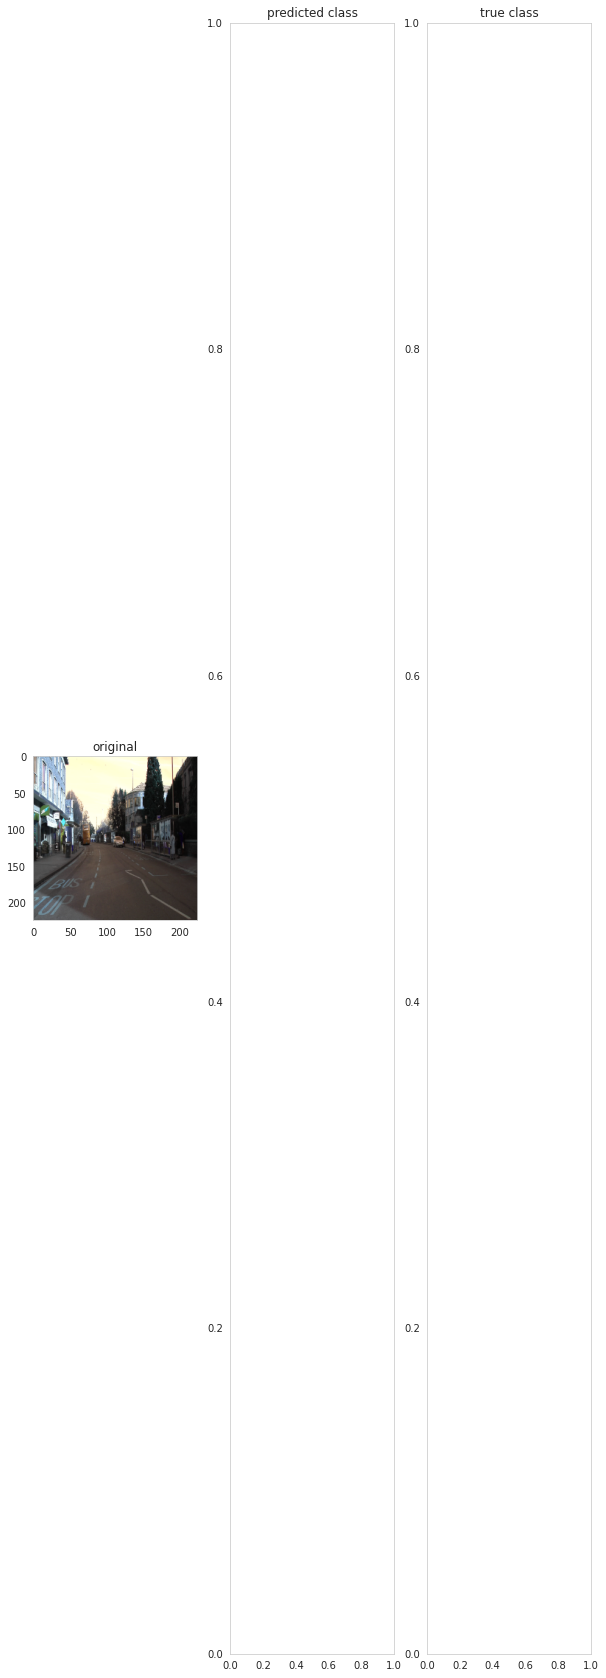

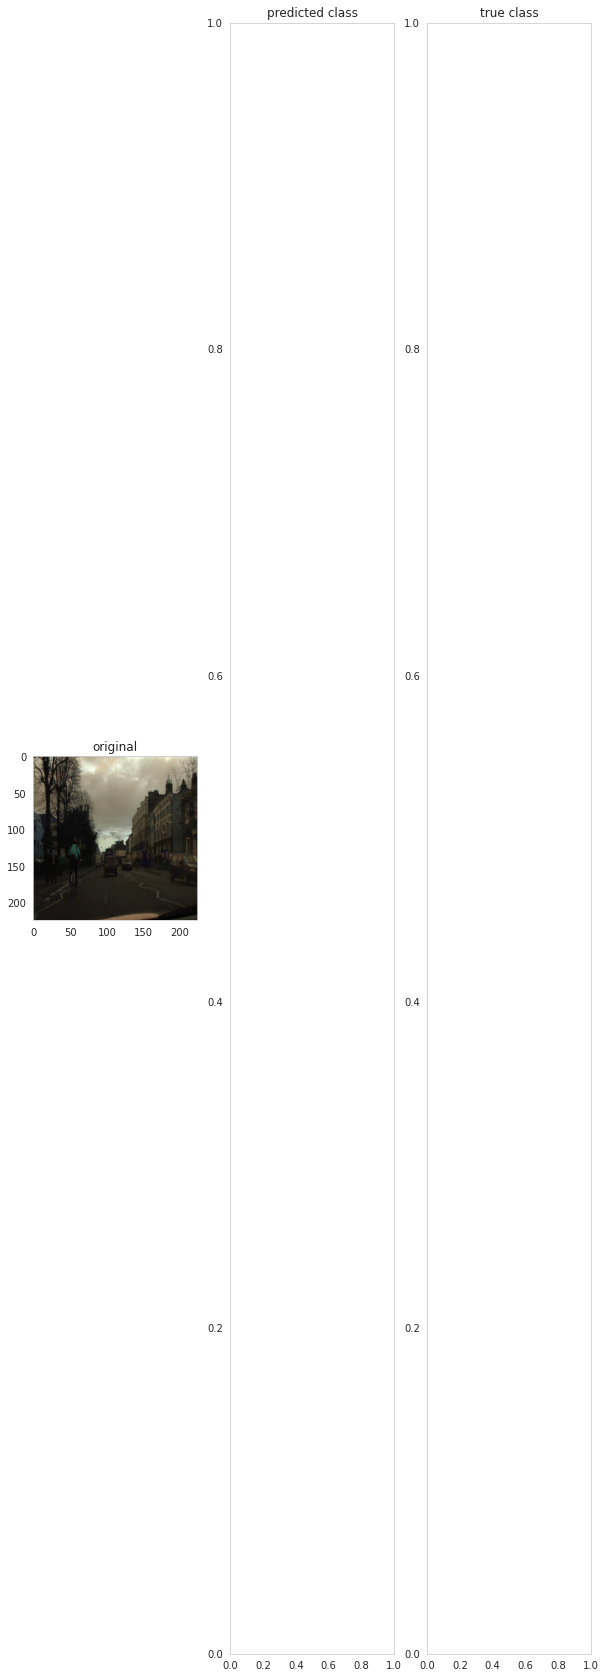

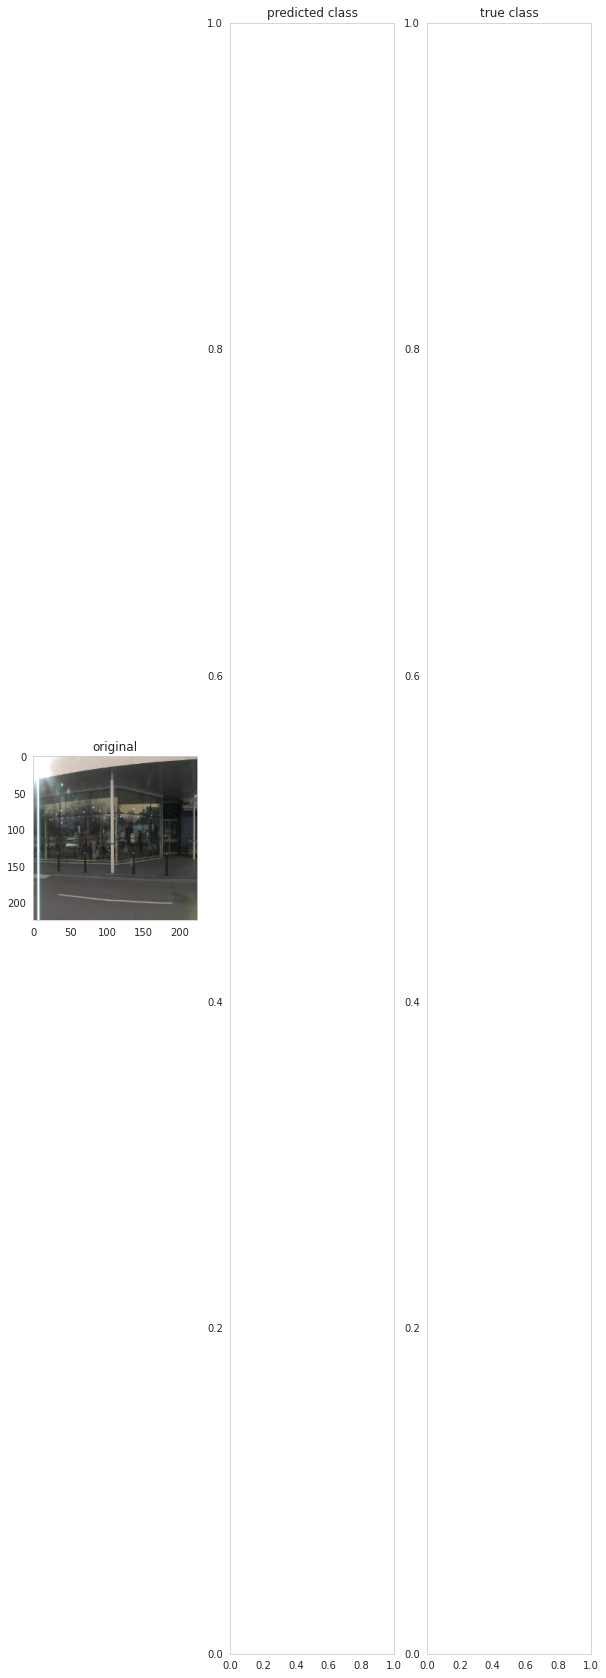

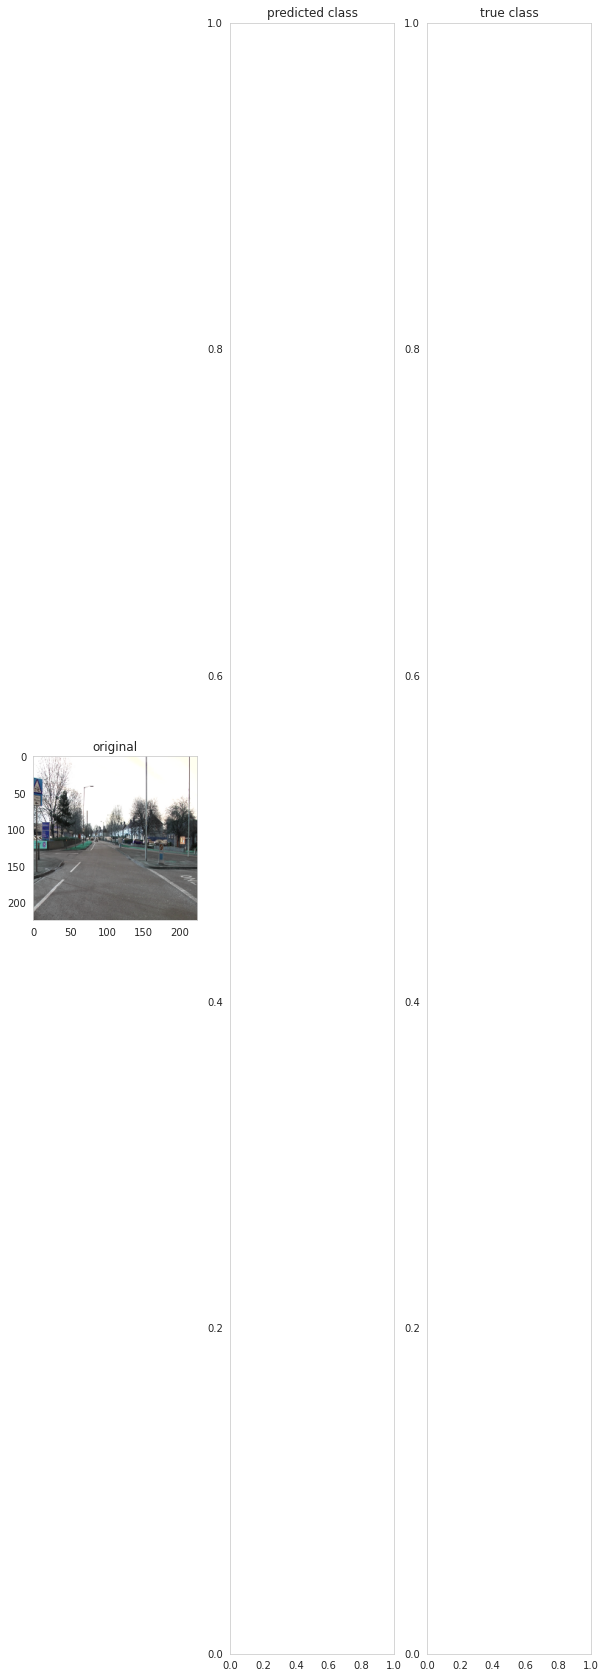

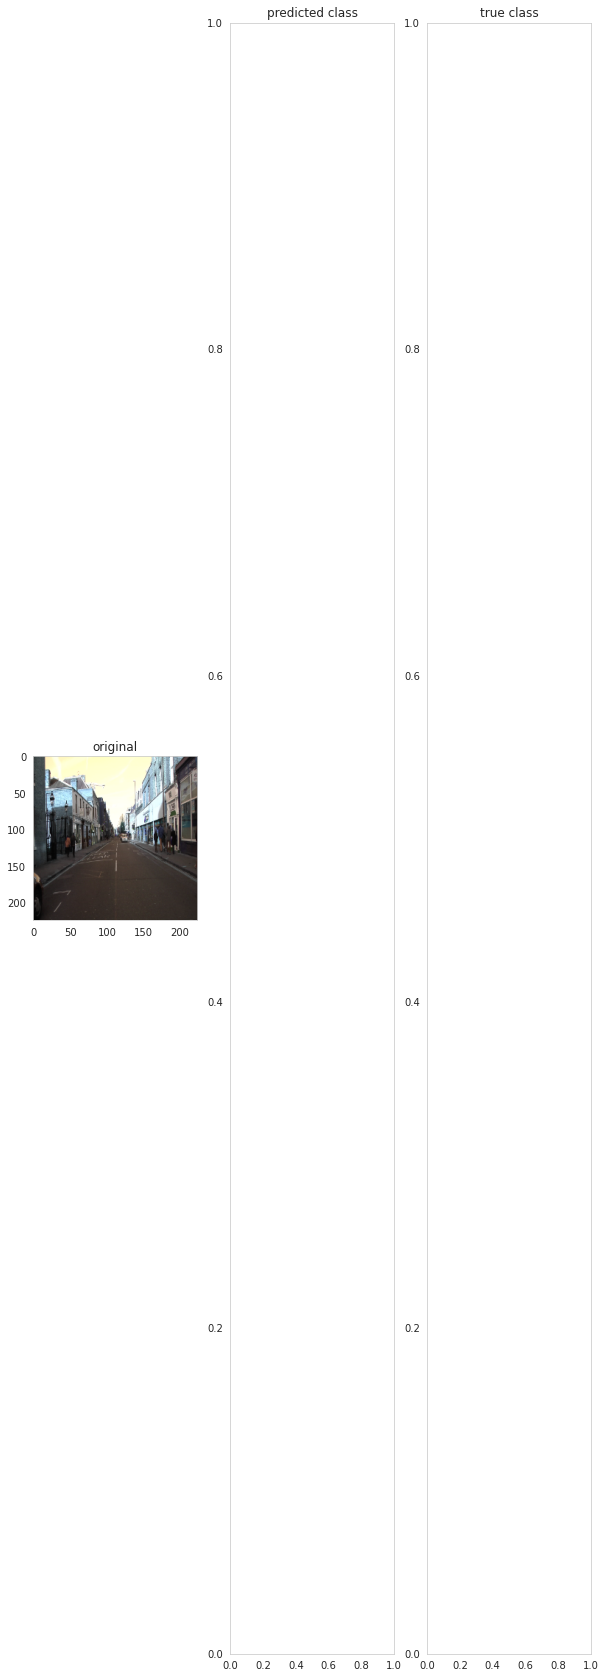

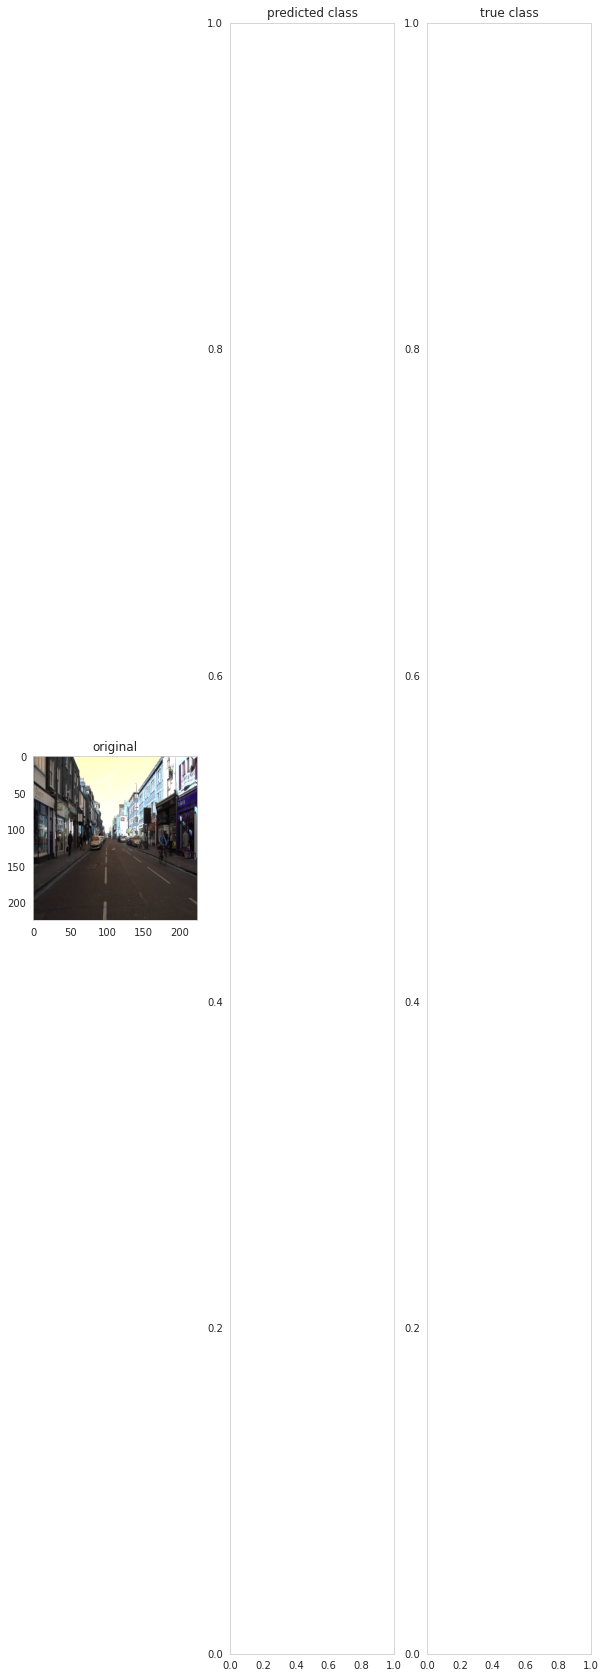

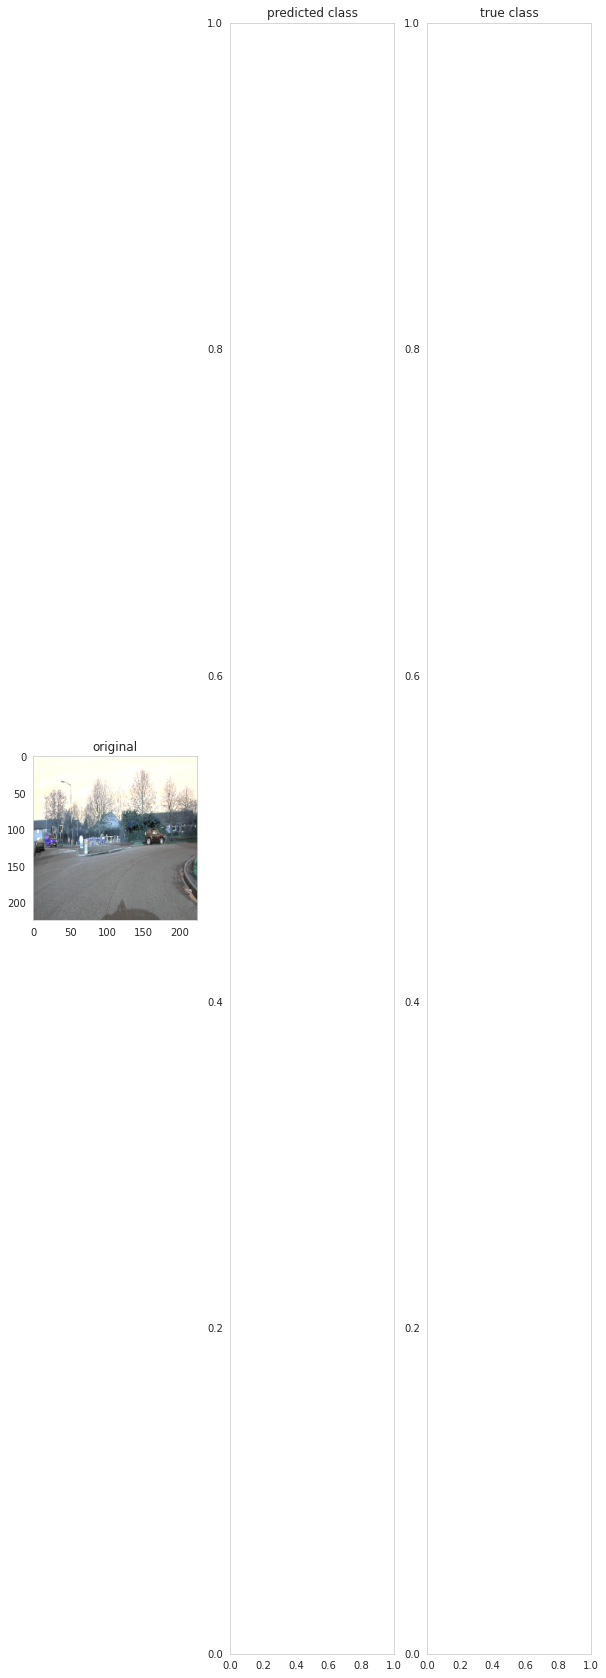

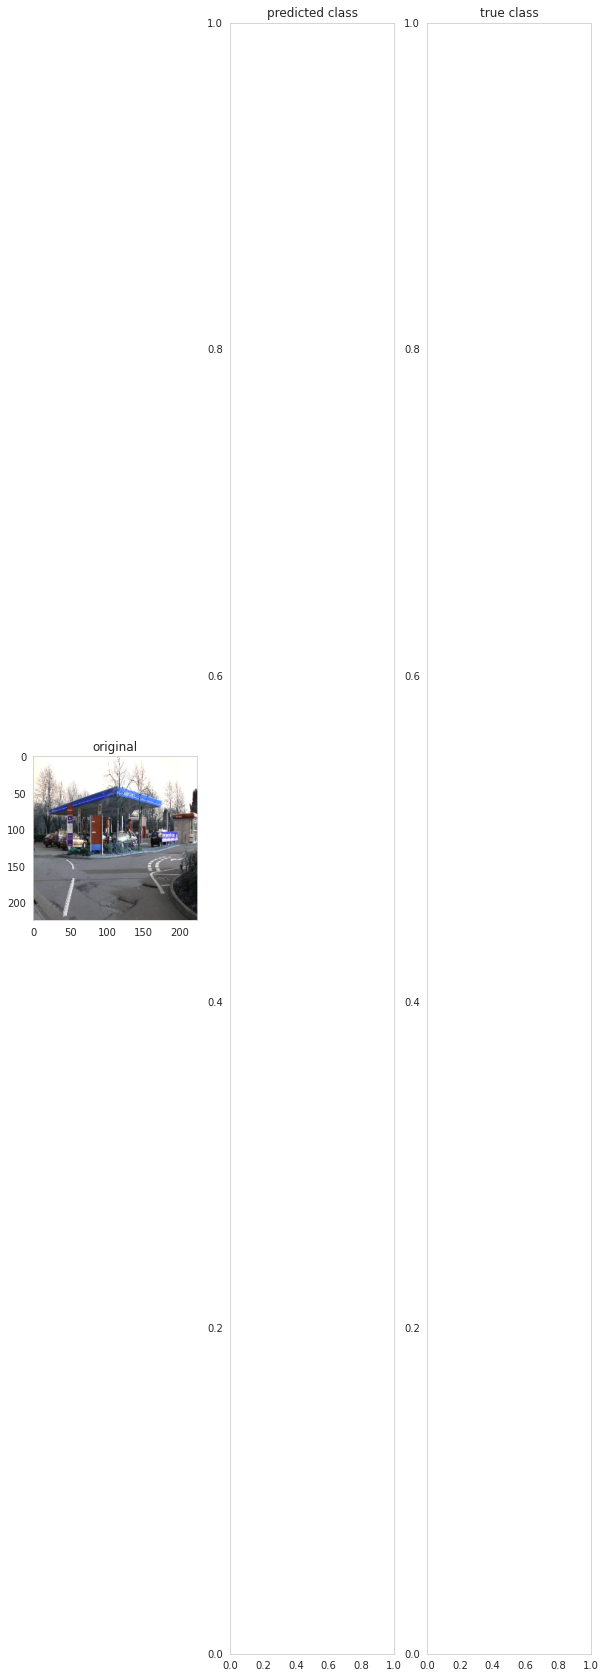

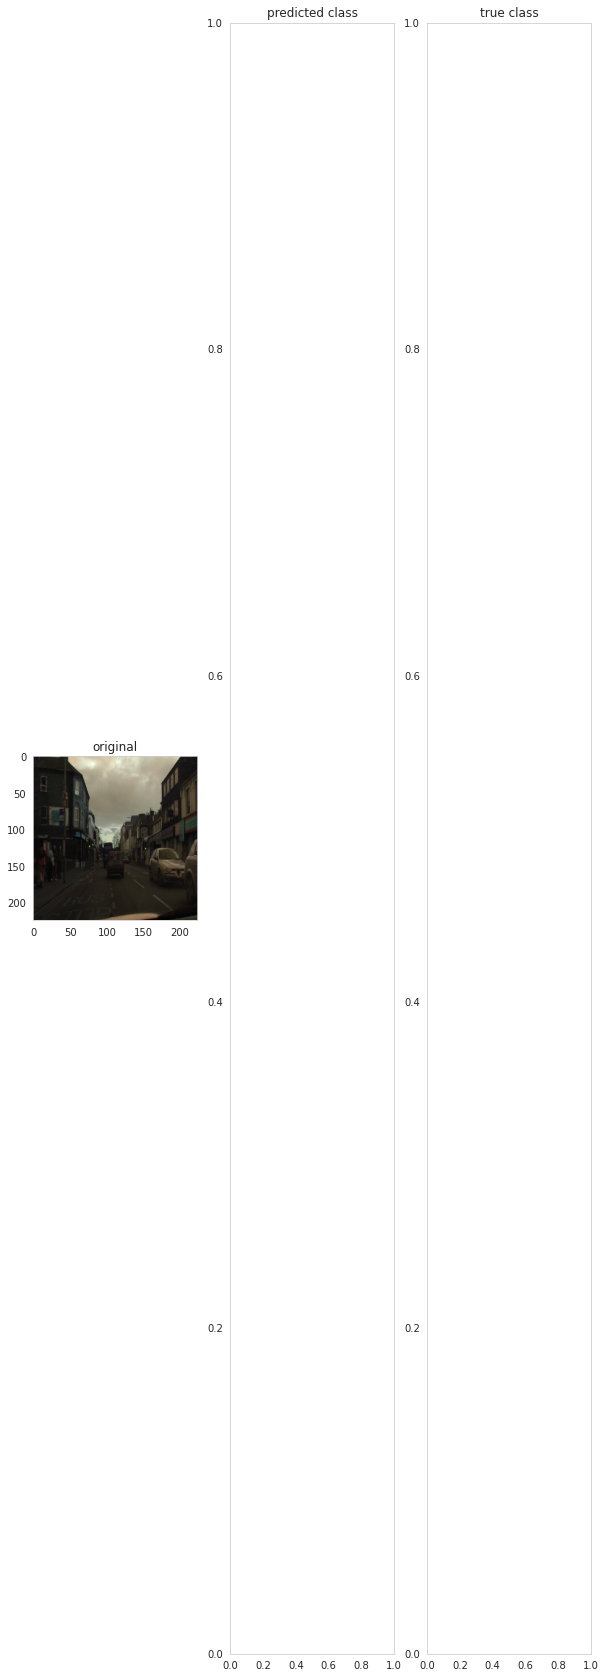

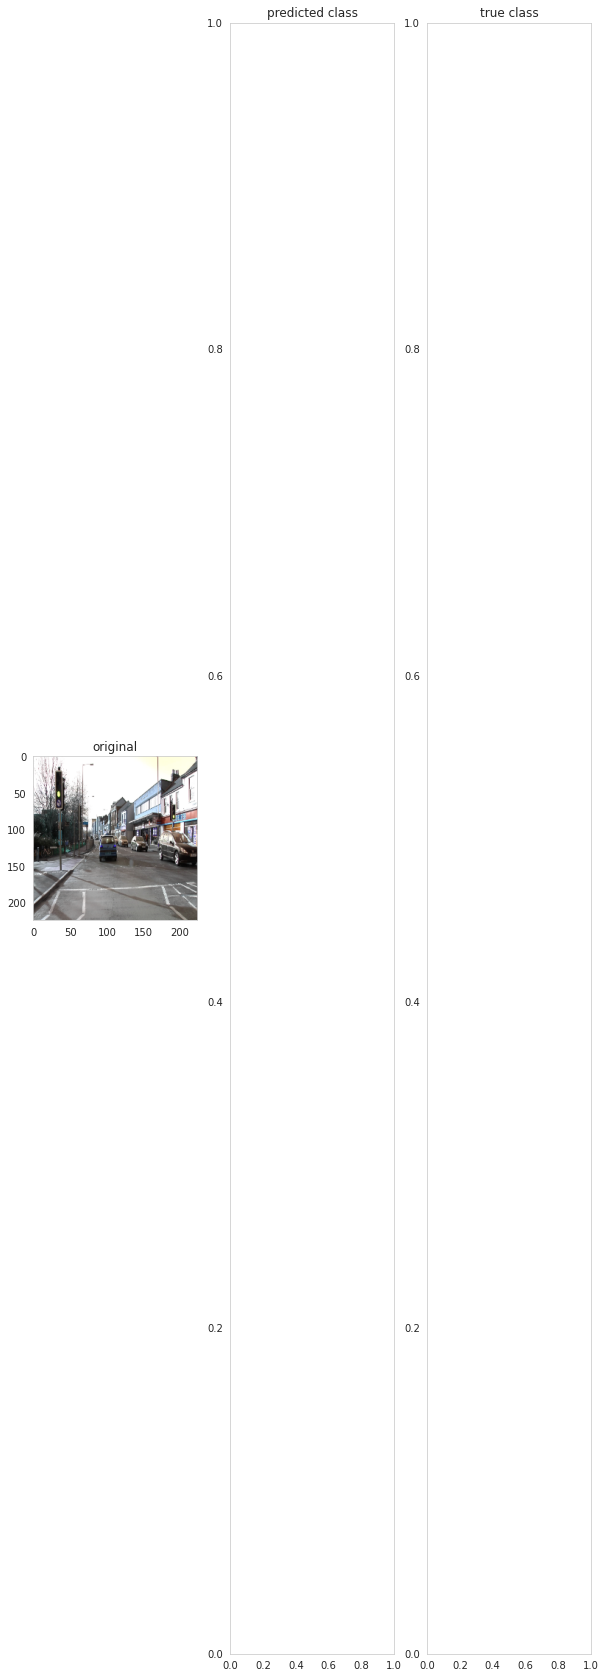

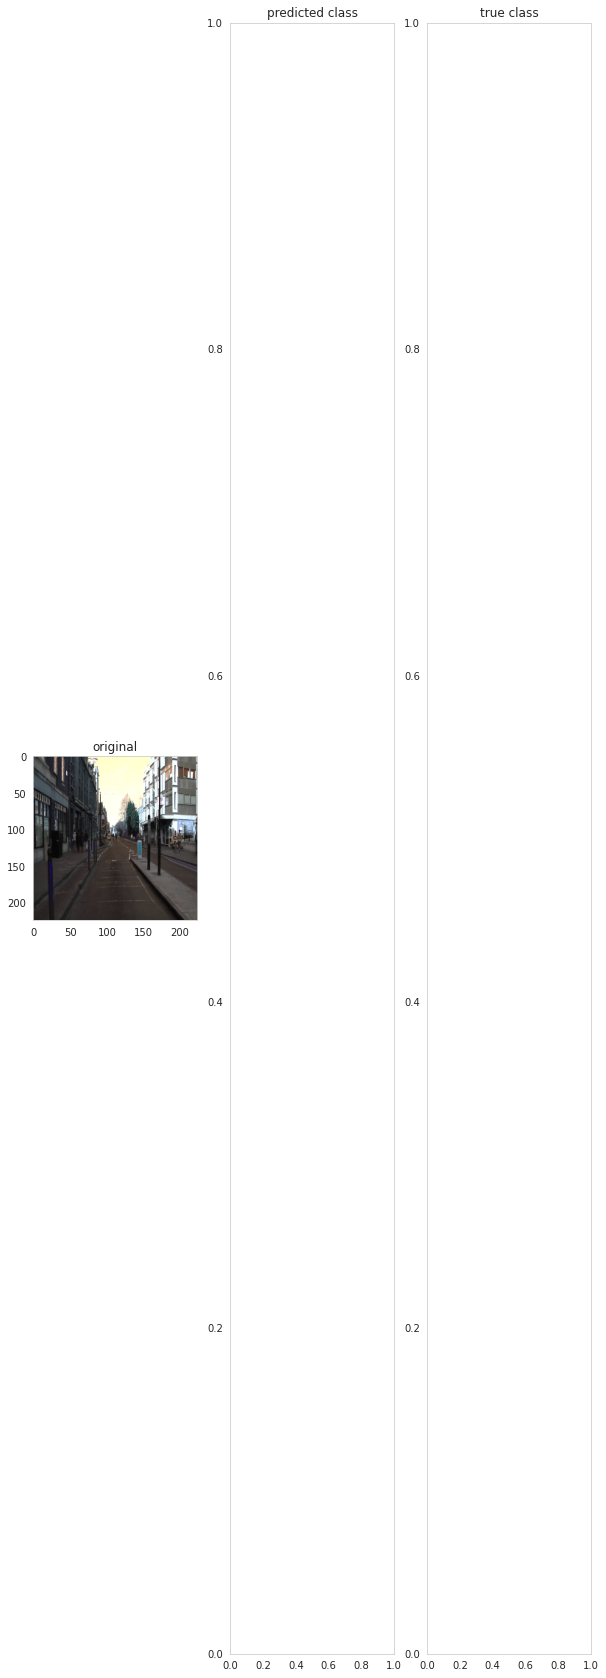

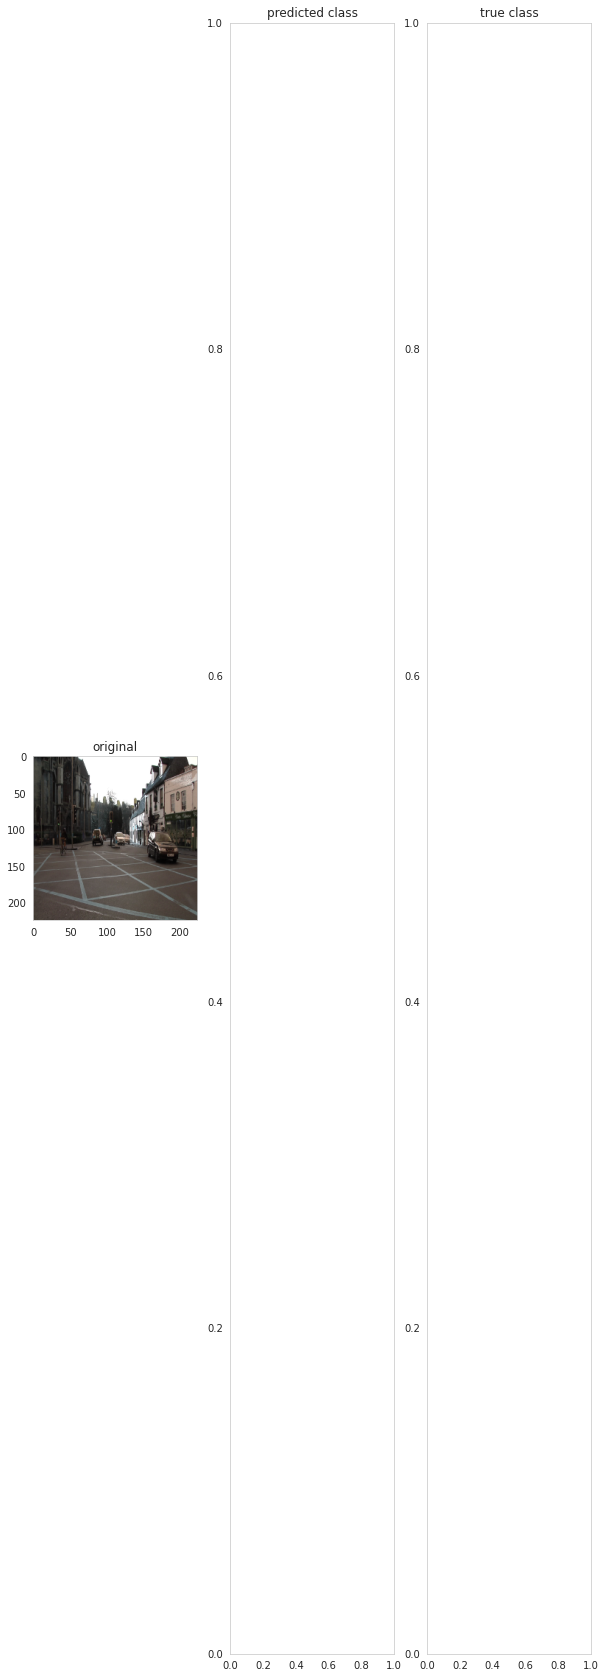

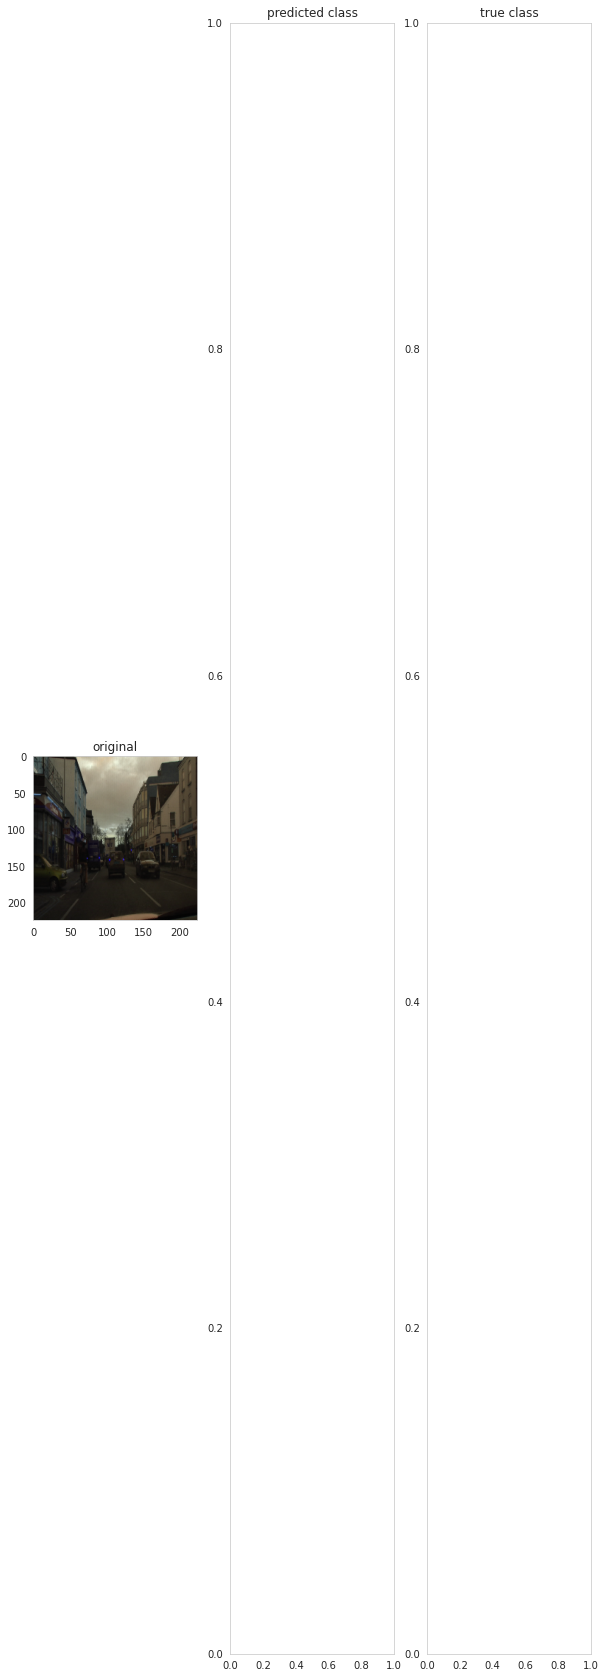

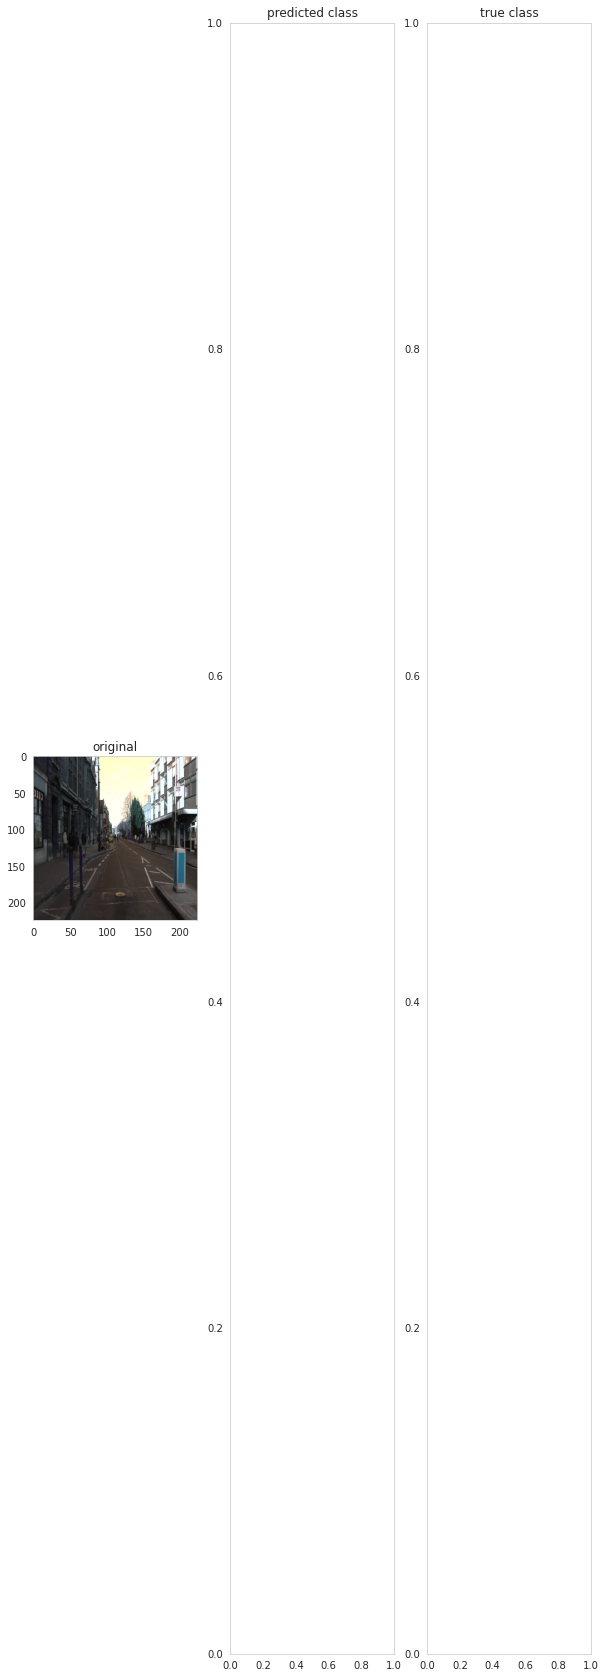

In [ ]:
shape=(224,224)
n_classes = 6
for i in range(30):
  img_is = (X_test[i] + 1)*(255.0/2)
  seg = y_predi[i]
  segtest = y_testi[i]

  fig = plt.figure(figsize=(10,30))
  ax = fig.add_subplot(1,3,1)
  ax.imshow(img_is/255.0)
  ax.set_title("original")

  ax = fig.add_subplot(1,3,2)
  ax.set_title("predicted class")

  ax = fig.add_subplot(1,3,3)
  ax.set_title("true class")
  plt.show()